# Amortized Posterior Estimation for Linear Regression

_Authors: Paul Bürkner, Lars Kühmichel_

In this notebook, we will show how to fit a linear regression model in bayesflow, which is amortized over the number of observations. For this notebook to run, you need to have the latest bayesflow dev version installed,
for example via:

In [1]:
# !pip install git+https://github.com/bayesflow-org/bayesflow.git@dev

We load a bunch of libraries and choose the keras backend, we want to use.
Here I use JAX but you can freely change that and the notebook will work all the same.

In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

np.set_printoptions(suppress=True)

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

First, we define our simulator, which in this case consists of a prior and likelihood, as well as of a "meta" simulator that is responsible for simulating
the number of simulations per dataset:

In [22]:
# TODO: do we have to require "batch_shape" to the function passed to meta_fn?
def meta(batch_shape):
    # N: number of observation in a dataset
    N = np.random.randint(5, 15)
    return dict(N=N)

def prior():
    # beta: regression coefficients (intercept, slope)
    beta = np.random.normal([2, 0], [3, 1])
    # sigma: residual standard deviation
    sigma = np.random.gamma(1, 1)
    return dict(beta=beta, sigma=sigma)

def likelihood(beta, sigma, N):
    # x: predictor variable
    x = np.random.normal(0, 1, size=N)
    # y: response variable
    y = np.random.normal(beta[0] + beta[1] * x, sigma, size=N)
    return dict(y=y, x=x)

We can combine these three functions into a bayesflow simulator via:

In [23]:
simulator = bf.simulators.make_simulator([prior, likelihood], meta_fn=meta)

We passed the `meta` simulator separately to the `meta_fn` argument to make sure
that the number of observations `N` constant within each *batch* of simulated datasets. This is required since, within each batch, the generated datasets need to have the same shape for them to be easily transformable to tensors for deep learning.

Let's see how sampling from the simulator works by sampling a batch of 2 datasets:

In [24]:
# Generate a batch of three training samples
sample_data = simulator.sample(3)
print(sample_data["N"])
print(sample_data["beta"].shape)
print(sample_data["sigma"].shape)
print(sample_data["x"].shape)
print(sample_data["y"].shape)

12
(3, 2)
(3, 1)
(3, 12)
(3, 12)


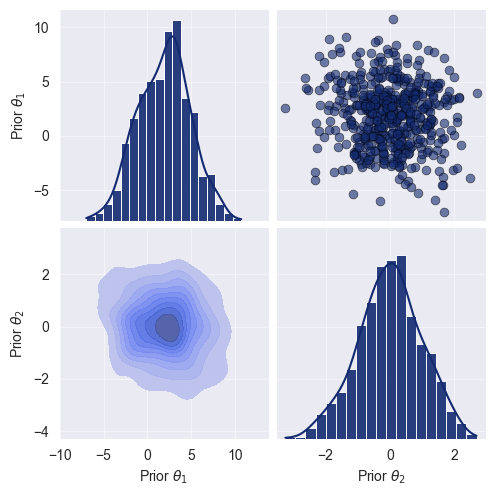

In [25]:
f = bf.diagnostics.plot_samples_2d(simulator.sample(500)["beta"], context="Prior")

To ensure that the training data generated by the simulator can be used for deep learning, we have do a bunch of transformations via `(data_)adapter` objects. Here, I build my own `adapter` from scratch but later on bayesflow will also provide default adapters that will already automate most of the commonly required steps.

In [26]:
adapter = (
    bf.Adapter()
    .broadcast("N", to="x")
    .as_set(["x", "y"])
    .constrain("sigma", lower=0)
    .standardize(exclude=["N"])
    .apply(include="N", forward=lambda n: np.sqrt(n), inverse=lambda n: n**2)
    .concatenate(["beta", "sigma"], into="inference_variables")
    .concatenate(["x", "y"], into="summary_variables")
    .rename("N", "inference_conditions")
)

I want to elaborate on a few adapter steps:

The `.broadcast("N", to="x")` transform will copy the value of `N` batch-size times to ensure that it will also have a `batch_size` dimension even though it was actually just a single value, constant over all datasets within a batch. The batch dimension will be inferred from `x` (this needs to be present during inference).

The `.as_set(["x", "y"])` transform indicates that both `x` and `y` are treated as sets. That is, their values will be treated as *exchangable* such that they will imply the same inference regardless of the values' order. This makes sense, since in linear regression, we can index the observations in arbitrary order and always get the same regression line.

The `.constrain("sigma", lower=0)` transform ensures that the residual standard deviation parameter `sigma` will always be positive. Without this constrain, the neural networks may attempt to predict negative `sigma` which of course would not make much sense.

Standardidazation via `.standardize()` is important for neural networks to learn
reliably without, for example, exploding or vanishing gradients during training. However, we need to exclude the variable `N` from standardization, via `standardize(exclude=["N"])`. This is because `N` is a constant within each batch of training data and can hence not be standardized. In the future, bayesflow will automatically detect this case so that we don't have to manually exclude such constant variables from standardization.

Let's check the shape of our processed data to be passed to the neural networks:

In [27]:
processed_data = adapter(sample_data)
print(processed_data["summary_variables"].shape)
print(processed_data["inference_conditions"].shape)
print(processed_data["inference_variables"].shape)

(3, 12, 2)
(3, 1)
(3, 3)


Those shapes are as we expect them to be. The first dimenstion is always the batch size which was 2 for our example data. All variables adhere to this rule since the first dimension is indeed 2.

For `summary_variables`, the second dimension is equal to `N`, which happend to be sampled as `14` for these example data. It's third dimension is `2`, since we have combined `x` and `y` into summary variables, each of which are vectors of length `N` within each simulated dataset.

For `inference_conditions`, the second dimension is just `1` because we have passed only the scalar variable `N` there.

For `inference_variables`, the second dimension is `3` because it consists of
`beta` (a vector of length `2`) and `sigma` (a scalar).

We will now define our inference and summary networks. As inference network, we will use a flow matching architecture and as summary network, we will use a deep set. The latter choice is important to reflect that fact that `x` and `y` as supposed to be sets and the deep set architecture ensures they are indeed correctly treated as such.

In [28]:
inference_network = bf.networks.FlowMatching()
summary_network = bf.networks.DeepSet(depth=2)

We can now define our posterior `approximator` consisting of the two networks and our data adapter from above.

In [29]:
approximator = bf.ContinuousApproximator(
   inference_network=inference_network,
   summary_network=summary_network,
   adapter=adapter,
)

We define some training hyperparameters such as the learning rate and optimization algorithm to apply before compile the approximator with these choices.

In [30]:
epochs = 30
num_batches = 128
batch_size = 64
learning_rate = keras.optimizers.schedules.CosineDecay(5e-4, decay_steps=epochs*num_batches, alpha=1e-6)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
approximator.compile(optimizer=optimizer)

Now, we are ready to train our approximator to learn posterior distributions for linear regression models. To achieve this, we will all `approximator.fit` passing the `simulator` and a bunch of hyperparameters that control how long we want to train:

In [31]:
history = approximator.fit(
    epochs=epochs,
    num_batches=num_batches,
    batch_size=batch_size,
    simulator=simulator,
)

INFO:bayesflow:Building dataset from simulator instance of SequentialSimulator.
INFO:bayesflow:Using 20 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 295ms/step - loss: 1.3778 - loss/inference_loss: 1.3778
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.8845 - loss/inference_loss: 0.8845
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.7419 - loss/inference_loss: 0.7419
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.7068 - loss/inference_loss: 0.7068
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.6464 - loss/inference_loss: 0.6464
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.6371 - loss/inference_loss: 0.6371
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.6357 - loss/inference_loss: 0.6357
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.5926 - loss/inference_loss: 0.5926
Epoch 9/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.5842 - loss/inference_loss: 0.5842
Epoch 10/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.5931 - loss/inference_loss: 0.5931
Epoch 11/30
128/1

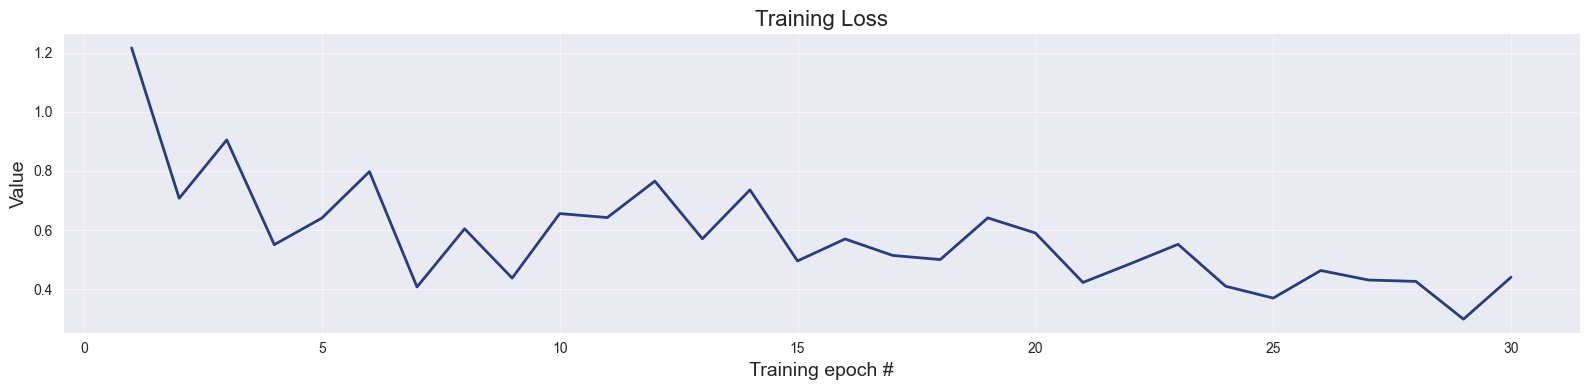

In [32]:
# Visualize losses
f = bf.diagnostics.plot_losses(
    train_losses=np.array(history.history["loss"]).astype(np.float32)
)

The first few steps of training may take a little longer due to network compilation overhead. The total training time for this example is around 2 minutes on a modern laptop.

## Diagnostics

Let's check out the resulting inference. Say we want to obtain 1000 posterior samples from our approximated posterior of a simulated dataset where we know the ground truth values.

In [33]:
# Set the number of posterior draws you want to get
num_samples = 1000

# Simulate validation data
val_sims = simulator.sample(200)
# exclude parameters from the conditions used as validation data
conditions = {k: v for k, v in val_sims.items() if k != "beta" and k != "sigma"}

# obtain num_samples samples of the parameter posterior for every valididation dataset
pdraws = approximator.sample(conditions=conditions, num_samples=num_samples)

In [34]:
pdraws["beta"].shape

(200, 1000, 2)

Initial sanity checks of the posterior samples look good. `pdraws["beta"]` has shape `(200, 2000, 2)` which makes sense since we asked for inference of a 200 data sets (first dimension is 200), for which we wanted to generated 1000 posterior samples (second dimension is 1000). The third dimension is 2, since the `beta` variable was defined as a vector of length 2 (intercept and slope).

In [35]:
pdraws["sigma"].min()

7.285830679406575e-07

The minimun posterior sample of `sigma` is positive indicating that our positivity enforcing constraing in the data adapter has indeed worked.

Let's plot the joint posterior distribution of `beta` (both intercept and slope). Based on how we generated this particular dataset, we would expect the posteriors of `beta` to vary around its true values from `val_sims["beta"]`. Of course, if this was real data, we wouldn't know the ground truth values, so had no reference to check against. Hence, it is good to first perform some inference on simulated data as a diagnostic for whether the approximator has learned to approximate the true posteriors well enough. We will examplariy check the posterior of the first dataset:

[ 0.17943215 -1.54160175]


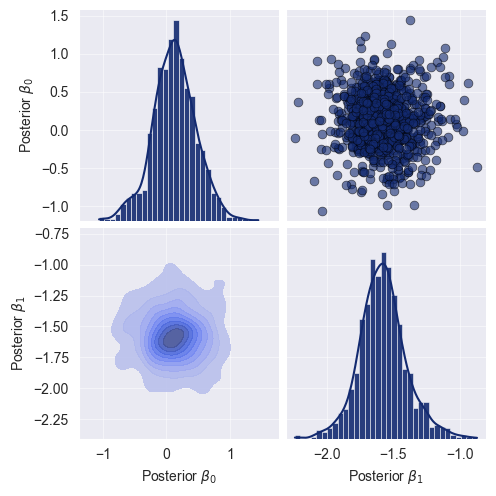

In [53]:
# trust beta value from which the first datset was generated
print(val_sims["beta"][0])

# plot corresponding posterior samples
f = bf.diagnostics.plot_samples_2d(pdraws["beta"][0], context="Posterior", variable_names=[r"$\beta_0$", r"$\beta_1$"])

The true parameter values of the first dataset are indeed well covered by the posterior. Let's check this more systematically for all validation datasets:

In [68]:
pdraws['beta'].shape[-1]

2

In [69]:
val_sims['beta'].shape[-1]

2

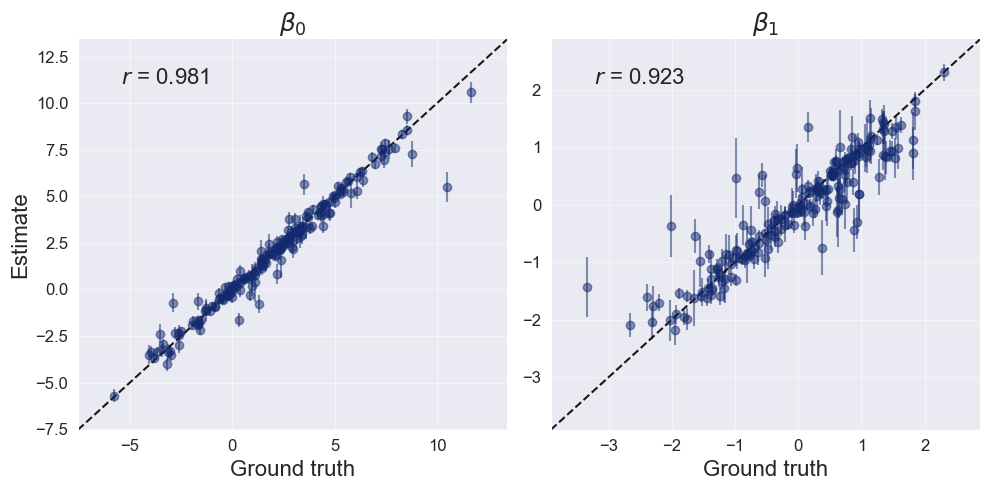

In [73]:
f = bf.diagnostics.plot_recovery(
    pdraws["beta"], val_sims["beta"],
    variable_names=[r"$\beta_0$", r"$\beta_1$"]
)

Accuracy looks good for most datasets There is some more variation especially for $\theta_1$ but this is not necessarily a reason for concern. Keep in mind that perfect accuracy is not the goal of bayesflow inference. Rather, the goal is to estimate the correct posterior as close as possible. And this correct posterior might very well be far away from the true value for some datasets. In fact, we would fully expect the true value to sometimes be at the tail of the posterior. If this was not the case, than our posterior approximation may be too wide. Unfortunately, in many cases we don't have access to the correct posterior, so we need a method that provides us with an indication of the posterior approximations' accuracy without. This is where simulation-based calibration (SBC) comes into play. In short, if the true values are simulated from the prior used during inference (as is the case for our validatian data above), We would expect the rank of the true parameter value to be uniformly distributed from 1 to `num_samples`.

There are multiple graphical methods that use this property for diagnostics. For example, we can use histograms together with an uncertainty band within which we would expect the histogram bars to be if the rank statistics were indeed uniform.

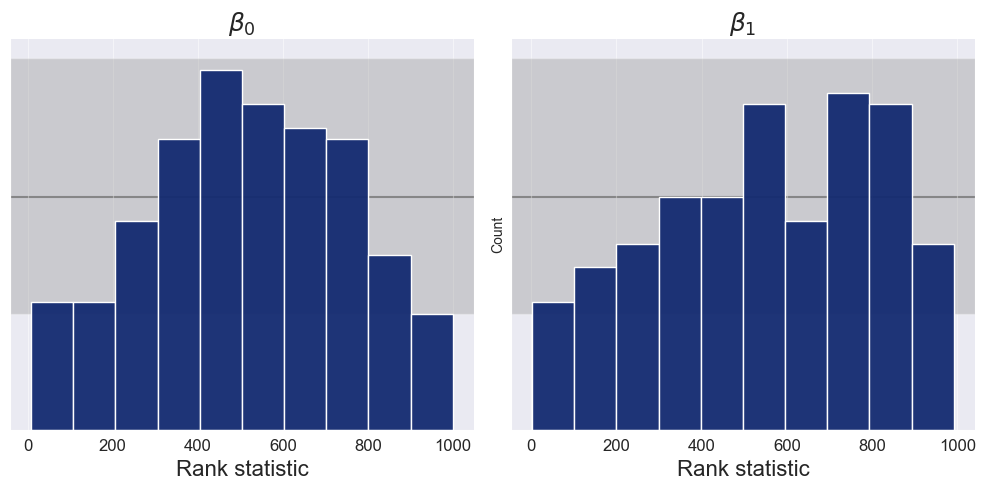

In [77]:
f = bf.diagnostics.plot_sbc_histograms(
    pdraws["beta"], 
    val_sims["beta"],
    variable_names=[r"$\beta_0$", r"$\beta_1$"]
)

The histograms don't look ideal yet but also not too bad. Inference on the intercept $\beta_0$ is a bit underconfident. That is, the approximate posteriors are a bit wider than the corresponding correct posteriors. The SBC histograms have some drawbacks on how the confidence bands are computed, so we recommend using another kind of plot that is based on the empirical cumulative distribution function (ECDF). For the ECDF, we can compute better confidence bands than for histograms, to the SBC ECDF plot is usually preferable.

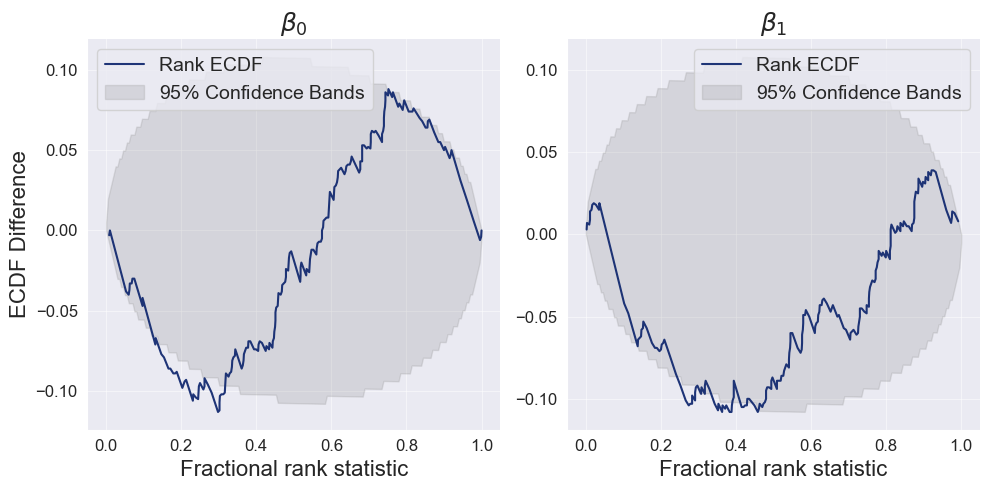

In [78]:
f = bf.diagnostics.plot_sbc_ecdf(pdraws["beta"], val_sims["beta"], variable_names=[r"$\beta_0$", r"$\beta_1$"], difference=True)

The plot confirms that the approximate posteriors are largely well calibrated, except for the small underconfidence in the posteriors of $\beta_0$ that we had already seen in the histograms. Likely, for fully well calibrated inference, we would have to train the approximator a little longer, but that's okay. After all, we can effort a little more training time since afterwards, inference on any number of new (real or simulated) datasets is very fast due to amortization.

After having convinced us that the posterior approximation are overall reasonable, we can check how much and what kind of information in the data we encode in the posterior. Specifically, we might want to look at two interesting scores: (a) The posterior contraction, which measures how much smaller the posterior variance is relative to the prior variance (higher values indicate more contraction relative to the prior). (b) The posterior z-score which indicates the standardized difference between the posterior mean and the true parameter value. Since the posterior z-score requires the true parameter values, it can only be computed in simulated data settings.

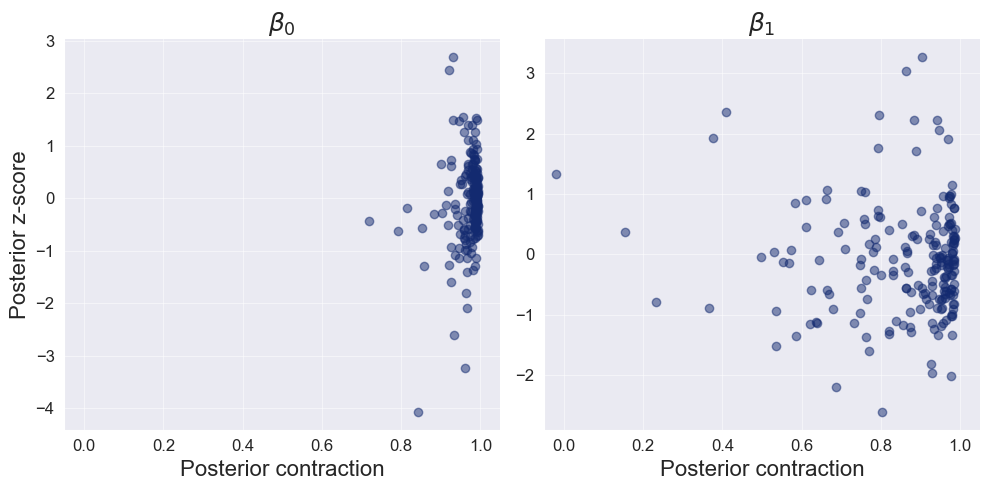

In [79]:
f = bf.diagnostics.plot_z_score_contraction(pdraws["beta"], val_sims["beta"], variable_names=[r"$\beta_0$", r"$\beta_1$"])

We clearly see strong posterior contraction in almost all posteriors of $\beta_0$ and in most posteriors of $\beta_1$. In the latter case, there are some notable exceptions where little learning from prior to posterior has taken place. Most likely this is because the variance of the sample predictor value $x$ was small, leading to reduced information about the slope $\beta_1$. In terms of posterior z-score, most estimates are between -2 and 2, which makes sense if our posterior is approximately normal and well calibrated. However, again, there are some notable exceptions with quite large posterior z-scores over greater than 3 in absolute values. These may be cases, where the learned posterior approximation was not yet fully accurate. So likely, these extreme cases would vanish if we trained our approximator a little longer. 